<a href="https://colab.research.google.com/github/YKochura/ml-kpi/blob/76048b9b083d2e2b9319420ba4ed6199894d3191/tutor/support_vector_machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Метод опорних векторів

- [1. Метод опорних векторів](#svm)
- [2. Прямий підхід – SVM з жорстким зазором](#hard-margin-svm)
- [3. Прямий підхід — SVM з м’яким зазором ](#soft-margin-svm)
- [4. Розв'язання прямої задачі оптимізації](#solving-primal-svm)
   - [4.1 Завісна функція втрат (Hinge loss)](#hinge-loss)
   - [4.2 Оновлена цільова функція](#updated-objective-function)
   - [4.3 Субградієнтний спуск](#subgradient-descent)
- [5. Реалізація прямого підходу](#primal-implementation)
   - [5.1 Демонстраційний набір даних](#toy-dataset)
   - [5.2 Визначення класу SVM ](#primal-svm-class)
   - [5.3 Навчання та тестування SVM](#train-test-svm)  
   - [5.4 Візуалізація границі прийняття рішення](#decision-boundary)
- [6. Двоїстий підхід](#dual-approach)
    - [6.1 Підсумок про множники Лагранжа](#recap-lagrange-multipliers)
    - [6.2 Лагранжіан](#recap-lagrangian)
    - [6.3 Проблема дуальної оптимізації](#dual-optimization-problem)
- [7. Прямий (primal) та двоїстий (dual) підходи](#primal-vs-dual)
- [8. Ядра / Нелінійні SVM](#kernel-svms)
    - [8.1 Що таке ядро?](#what-is-a-kernel)
    - [8.2 Для чого потрібні ядра?](#what-are-kernels-good-for)
    - [8.3 Приклад](#kernel-example)
    - [8.4 Чи можна також використовувати ядра в прямій (primal) формі SVM?](#kernel-in-primal-svm)
- [9. Джерела та додаткова література](#sources)

## 1. Метод опорних векторів <a class="anchor" id="svm"></a>

**Метод опорних векторів** (англ. Support Vector Machine, скорочено SVM) &mdash; метод керованого навчанням (supervised learning) для класифікації та регресійного аналізу даних. SVM  є найвідомішими представниками класу [ядрових методів](https://uk.wikipedia.org/wiki/%D0%AF%D0%B4%D1%80%D0%BE%D0%B2%D1%96_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D0%B8).

Перша версія SVM була запропонована у 1963 році &mdash; простий лінійний бінарний класифікатор. Припустимо, що нам дано набір даних:

 $$D = \big \{ \mathbf{x}_n, y_n \big \}_{n=1}^N,$$
  де $\mathbf{x}_n \in \mathbb{R}^D$ &mdash; вхідні вектори ознак, $y_n \in \{-1, +1 \}$ &mdash; бінарні класи. Лінійна (у випадку жорсткого розділення &mdash; hard-margin) SVM виконує розділення двох класів за допомогою гіперплощини розмірності $(D-1)$.

Особливістю SVM є те, що цей метод використовує не будь-яку гіперплощину, а таку, яка максимізує відстань між собою та найближчими точками з обох класів. Така гіперплощина називається гіперплощиною з максимальним зазором (maximum-margin hyperplane):

<img src="https://docs.google.com/uc?export=download&id=17regyN5uSblDoPZXV62DbXYkov7wsbO7" width="800"/>


Термін зазор (margin) означає відстань між гіперплощиною класифікації та найближчими точками навчальної вибірки.

Існує два основних типи SVM: прямі (primal) та двоїсті (dual). Хоча більшість досліджень у минулому зосереджувалася на двоїстих SVM, обидва підходи можуть бути використані для нелінійної класифікації.


## 2. Прямий підхід – SVM з жорстким зазором (hard-margin) <a class="anchor" id="hard-margin-svm"></a>

Під час навчання SVM наша мета &mdash; знайти таку гіперплощину, яка максимізує зазор (margin) між двома множинами точок. Ця гіперплощина повністю визначається найближчими до неї точками, які називаються **опорними векторами** (support vectors).

Рівняння гіперплощини має вигляд:

$$\langle \mathbf{w}, \mathbf{x} \rangle + b = 0,$$

де $\langle \cdot, \cdot \rangle$ — це скалярний добуток, а $\mathbf{w}$ — нормальний вектор до гіперплощини.

Якщо приклад $\mathbf{x}_i$ лежить праворуч від гіперплощини (тобто має позитивну мітку), то:
$$\langle \mathbf{w}, \mathbf{x}_i \rangle + b \gt 0.$$

Якщо ж $\mathbf{x}_i$ лежить ліворуч (тобто має негативну мітку), то:
$$\langle \mathbf{w}, \mathbf{x}_i \rangle + b \lt 0.$$

Опорні вектори лежать точно на межі зазору, і оптимальна розділяюча гіперплощина повинна мати однакову відстань до всіх опорних векторів.

У цьому сенсі гіперплощина з максимальним зазором знаходиться між двома розділяючими гіперплощинами, які визначаються саме опорними векторами:

<img src="https://docs.google.com/uc?export=download&id=1kQ8hnTrLxTYLG08MGnxENcYqODdT2bK6" width="450"/>

### Мета 1:
Під час виведення формального рівняння гіперплощини з максимальним зазором ми припускаємо, що дві граничні гіперплощини мають вигляд:   
$$\langle \mathbf{w}, \mathbf{x}_{+} \rangle + b = +1$$
$$\langle \mathbf{w}, \mathbf{x}_{-} \rangle + b = -1$$


Іншими словами: ми хочемо, щоб усі точки навчальної вибірки знаходилися на відстані не менше 1 від розділяючої гіперплощини — в обидва боки. Для позитивних прикладів (з міткою $y_n = +1$) повинна виконуватись умова:

$$\langle \mathbf{w}, \mathbf{x}_n \rangle + b \ge +1.$$

Для негативних прикладів (з міткою $y_n = -1$):
$$\langle \mathbf{w}, \mathbf{x}_n \rangle + b \le -1.$$

Ці дві умови можна об'єднати в одну:
$$y_n(\langle \mathbf{w}, \mathbf{x}_n \rangle + b) \ge 1.$$

Це й є перша мета:

> Ми хочемо отримати розділяючу гіперплощину, яка правильно класифікує всі приклади навчальної вибірки.


### Мета 2:
Друга мета — максимізувати зазор (margin) навколо розділяючої гіперплощини.

Зазор задається як:
$$\frac{1}{\Vert \mathbf{w} \Vert}.$$

Максимізацію зазору можна сформулювати так:
$$ \max_{\mathbf{w}, b} \frac{1}{\Vert \mathbf{w} \Vert}$$

Замість максимізації цієї величини зручно мінімізувати:
$$
\min_{\mathbf{w}, b} \frac{1}{2} \Vert \mathbf{w} \Vert^2
$$

Це спрощує обчислення градієнта під час оптимізації.

### Об'єднана мета
Об’єднавши першу та другу мету, отримуємо наступну задачу оптимізації:   
$$
\min_{\mathbf{w}, b} \frac{1}{2} \Vert \mathbf{w} \Vert^2
$$
$$
\text{за умовою: } y_n(\langle \mathbf{w}, \mathbf{x}_n \rangle + b) \ge 1 \;\; \forall n = 1, ..., N
$$

Іншими словами:

> Ми хочемо знайти такі значення $\mathbf{w}$ та $b$, які максимізують зазор і при цьому правильно класифікують всі приклади.

Такий підхід називається методом опорних векторів з жорстким зазором (hard-margin SVM). "Жорстким" (hard), тому що не дозволяє жодних порушень вимог до зазору — жодна точка не може потрапити всередину або за межі цього зазору.

## Виведення рівняння зазору <a class="anchor" id="margin-derivation"></a>

Ширину зазору можна вивести кількома способами (див. розділи 12.2.1–12.2.2 у книзі [Mathematics for Machine Learning book](https://mml-book.com)). Проте зрозуміліше за все це пояснюється у  [цій лекції MIT про SVMs](https://www.youtube.com/watch?v=_PwhiWxHK8o).

Виведення базується на тих самих припущеннях, які ми вже розглядали раніше:
$$\langle \mathbf{w}, \mathbf{x}_{+} \rangle + b = +1$$
$$\langle \mathbf{w}, \mathbf{x}_{-} \rangle + b = -1$$

З урахуванням мітки кожного прикладу це можна переписати як:
$$y_i (\langle \mathbf{w}, \mathbf{x}_{i} \rangle + b) -1 = 0$$

Нехай маємо позитивний приклад $\mathbf{x}{+}$, що лежить на правій гіперплощині, та негативний приклад $\mathbf{x}{-}$, що лежить на лівій гіперплощині. Векторна відстань між цими точками — це $(\mathbf{x}{+} - \mathbf{x}{-})$.

Щоб знайти ширину зазору, потрібно обчислити ортогональну проєкцію цього вектора на напрямок, перпендикулярний до розділяючої гіперплощини. Це можна зробити, помноживши $(\mathbf{x}{+} - \mathbf{x}{-})$ на унітарний вектор, перпендикулярний до гіперплощини. Ми знаємо, що вектор $\mathbf{w}$ є нормаллю до цієї гіперплощини, тому поділивши його на його норму $||\mathbf{w}||$, отримаємо потрібний унітарний вектор:

<img src="https://docs.google.com/uc?export=download&id=1f48I-8-ndnkMy97FpeV8hUXGVH9HCm3S" width="500"/>

$$
\begin{align*}
\text{ширина} &= (\mathbf{x}_{+} - \mathbf{x}_{-}) \cdot \frac{\mathbf{w}}{||\mathbf{w}||} \\
&= \frac{\mathbf{x}_{+} \cdot \mathbf{w}}{||\mathbf{w}||} - \frac{\mathbf{x}_{-} \cdot \mathbf{w}}{||\mathbf{w}||}
\end{align*}
$$

Для позитивного прикладу $\mathbf{x}{+}$ маємо $y+ = +1$, тому:
$$(\langle \mathbf{w}, \mathbf{x}_{+} \rangle = 1 - b$$

Для негативного прикладу $\mathbf{x}{-}$ маємо $y- = -1$, тому:
$- (\langle \mathbf{w}, \mathbf{x}_{-} \rangle) = 1 + b$

Таким чином отримуємо:

$$
\begin{align*}
\text{ширина} &= (\mathbf{x}_{+} - \mathbf{x}_{-}) \cdot \frac{\mathbf{w}}{||\mathbf{w}||} \\
&= \frac{\mathbf{x}_{+} \cdot \mathbf{w}}{||\mathbf{w}||} - \frac{\mathbf{x}_{-} \cdot \mathbf{w}}{||\mathbf{w}||} \\
&= \frac{(1 - b) + (1 + b)}{||\mathbf{w}||}\\
&= \frac{2}{||\mathbf{w}||}\\
\end{align*}
$$

Отже, ширина між двома граничними гіперплощинами дорівнює  $\frac{2}{||\mathbf{w}||}$. А відстань від розділяючої гіперплощини до кожної з граничних — це половина цієї величини: $\frac{1}{||\mathbf{w}||}$



##  3. Прямий підхід — SVM з м’яким зазором <a class="anchor" id="soft-margin-svm"></a>

У більшості реальних задач наявні дані не є лінійно роздільними. Навіть якщо розділення можливе, іноді краще мати модель, яка добре відокремлює основну масу даних, ігноруючи **зашумлені приклади** або **викиди**. Це стало підставою для розширення початкового жорсткого SVM (hard-margin SVM) до так званого SVM з м’яким зазором (soft-margin SVM).

SVM з м’яким зазором **дозволяє порушення вимоги щодо зазору** (тобто допускає помилки класифікації). Інакше кажучи, не всі навчальні приклади повинні бути правильно класифіковані. Деякі можуть знаходитися всередині зазору, а деякі — навіть на неправильному боці гіперплощини рішень. Але такі порушення мають свою ціну: чим більше приклад відхиляється від вимоги до зазору, тим вищу ціну ми за це платимо.

Щоб це реалізувати, ми вводимо так звані змінні послаблення (slack variables) $\xi_n$. Кожному тренувальному прикладу $(\mathbf{x}_n, y_n)$ призначається змінна $\xi_n \ge 0$. Вона вказує, наскільки сильно приклад порушує вимогу до зазору:

- Якщо $\xi_n = 0$, приклад лежить точно на межі зазору.
- Якщо $0 < \xi_n < 1$, приклад лежить всередині зазору, але на правильному боці гіперплощини.
- Якщо $\xi_n \ge 1$, приклад знаходиться на неправильному боці гіперплощини.


Модифікуємо нашу цільову функцію з урахуванням змінних послаблення наступним чином:
$$ \min_{\mathbf{w}, b, \mathbf{\xi}} \frac{1}{2} \Vert \mathbf{w} \Vert^2 + C \sum_{n=1}^N \xi_n $$

$$ \text{за умов:} $$

$$ \begin{equation}
y_n(\langle \mathbf{w}, \mathbf{x}_n \rangle + b) \ge 1 - \xi_n
\end{equation}$$

$$ \xi_i \ge 0 \;\; \forall n = 1, ..., N $$

Параметр $C$ — це регуляризаційний параметр, що керує компромісом між максимізацією зазору та мінімізацією помилок на тренувальних даних:
- Якщо $C$ мале, ми більше дбаємо про широкий зазор, ніж про правильну класифікацію кожної точки.
- Якщо $C$ велике, ми більше дбаємо про правильну класифікацію всіх точок, навіть якщо це призведе до зменшення зазору.


## 4. Розв'язання прямої задачі оптимізації <a class="anchor" id="solving-primal-svm"></a>

Теоретично пряму задачу оптимізації SVM можна розв’язувати різними способами. Один із найвідоміших підходів — це використання [завісної функції втрат](https://uk.wikipedia.org/wiki/%D0%97%D0%B0%D0%B2%D1%96%D1%81%D0%BD%D1%96_%D0%B2%D1%82%D1%80%D0%B0%D1%82%D0%B8)у поєднанні з [субградієнтним спуском](https://uk.wikipedia.org/wiki/%D0%A1%D1%83%D0%B1%D0%B3%D1%80%D0%B0%D0%B4%D1%96%D1%94%D0%BD%D1%82%D0%BD%D0%B8%D0%B9_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4).


### 4.1 Завісна функція втрат (Hinge loss) <a class="anchor" id="hinge-loss"></a>

Завісна функція втрат для істинної мітки $y \in {-1, +1}$ та передбачення $f(\mathbf{x}) = \langle \mathbf{w}, \mathbf{x} \rangle + b$ обчислюється як:

$$\ell(t)=\max \{0,1-t\} \quad \text{де} \quad t=y \cdot f(\mathbf{x})= y \cdot \big(\langle\mathbf{w}, \mathbf{x}\rangle+b\big)$$

Розглянемо кілька прикладів для розуміння цієї функції:
- Якщо навчальний приклад має мітку $y = -1$, і передбачення знаходиться на правильному боці зазору (тобто $f(\mathbf{x}) \le -1$), тоді $t \ge 1$ і втрати дорівнюють нулю: $\ell(t) = 0$.
- Те саме стосується прикладів із міткою $y = 1$, якщо $f(\mathbf{x}) \ge 1$.
- Якщо приклад ($y = 1$) знаходиться всередині зазору, але на правильному боці (тобто $0 < f(\mathbf{x}) < 1$), функція втрат повертає додатне значення.
- Якщо приклад ($y = 1$) на неправильному боці гіперплощини (тобто $f(\mathbf{x}) < 0$), втрати будуть ще більшими — вони лінійно зростають із віддаленням прикладу від гіперплощини рішень.

<img src="https://docs.google.com/uc?export=download&id=1ACsESLO5oIcQlMbX5VsRYCTUAi1Ric18" width="500"/>


### 4.2 Оновлена цільова функція <a class="anchor" id="updated-objective-function"></a>

З використанням завісної функції втрат ми можемо переформулювати задачу оптимізації для SVM з м’яким зазором. Для заданого набору даних $D = \big \{ \mathbf{x}_n, y_n \big \}_{n=1}^N$ прагнемо мінімізувати загальні втрати, які тепер мають вигляд:

$$
\min _{\mathbf{w}, b} \frac{1}{2}\|\mathbf{w}\|^{2} + C \sum_{n=1}^{N} \max \left\{0,1-y_{n}\left(\left\langle\mathbf{w}, \mathbf{x}_{n}\right\rangle+b\right)\right\}
$$

Це рівнозначно попередньому формулюванню (з використанням змінних послаблення $\xi_n$). Детальний розбір відповідності наведено в розділі 12.2.5 книги [Mathematics for Machine Learning book](https://mml-book.com).

### Три складові цільової функції <a class="anchor" id="two-parts"></a>

Наша цільова функція може бути поділена на три окремі частини:

- Частина 1: $\frac{1}{2}\|\mathbf{w}\|^{2}$

Ця частина також називається регуляризувальним доданком (regularization term). Вона виражає перевагу для рішень, які добре розділяють дані, тобто максимізують відстань до найближчих точок (margin). Теоретично, цей доданок можна було б замінити іншим регуляризатором, якщо потрібно задати іншу форму пріоритету.

- Частина 2: $\sum_{n=1}^{N} \max \left\{0,1-y_{n}\left(\left\langle\mathbf{w}, \mathbf{x}_{n}\right\rangle+b\right)\right\}$

Цей доданок називається емпіричними втратами (empirical loss). У нашому випадку це функція завісних втрат, яка штрафує ті рішення, які помиляються при класифікації навчальних прикладів. Теоретично цю частину також можна замінити іншою функцією втрат, якщо потрібно врахувати іншу стратегію штрафування.

- Частина 3: Гіперпараметр $C$

Цей параметр контролює компромісом між максимізацією зазору (через регуляризацію) та мінімізацією емпіричних втрат. Чим більше значення $C$, тим більше ми намагаємося правильно класифікувати всі приклади (навіть якщо доведеться зменшити зазор). Якщо $C$ менше — ми готові пожертвувати точністю класифікації заради більшого зазору.

### 4.3 Субградієнтний спуск <a class="anchor" id="subgradient-descent"></a>

Завісна функція втрат є недиференційованою в точці $t=1$. Тому ми не можемо безпосередньо обчислити градієнт. Однак ми можемо скористатися методом, який називається субградієнтний спуск, щоб розв’язати нашу задачу оптимізації.
Для спрощення виведення ми зробимо два припущення:
1. Припустимо, що зміщення $b$ входить до вектора ваг як перший компонент: $\mathbf{w} = [w_0, w_1, ..., w_D]$, де $w_0 = b$.
1. Ми поділимо завісні втрати на кількість прикладів у наборі.

Тоді наша функція втрат прийме вигляд:
$$
J(\mathbf{w}) = \frac{1}{2}\|\mathbf{w}\|^{2} + C \frac{1}{N} \sum_{n=1}^{N} \max \left\{0,1-y_{n}\left(\left\langle\mathbf{w}, \mathbf{x}_{n}\right\rangle\right)\right\}
$$

Ми можемо переписати це у вигляді, зручнішому для обчислення градієнта:
$$
J(\mathbf{w}) = \frac{1}{N} \sum_{n=1}^{N} \Big[ \frac{1}{2}\|\mathbf{w}\|^{2} + C \max \left\{0,1-y_{n}\left(\left\langle\mathbf{w}, \mathbf{x}_{n}\right\rangle\right)\right\}\Big]
$$

Субградієнт функції втрат визначається як:
$$
\nabla_{w} J(\mathbf{w}) = \frac{1}{N} \sum_{n=1}^N \left\{\begin{array}{ll}
\mathbf{w} & \text{якщо} \max \left(0,1-y_{n} \left(\langle \mathbf{w}, \mathbf{x}_{n} \rangle \right)\right)=0 \\
\mathbf{w}-C  y_{n} \mathbf{x}_{n} & \text { інакше }
\end{array}\right.
$$


Завдяки цій формулі можна застосувати стохастичний градієнтний спуск (SGD), щоб знайти мінімум функції $J(\mathbf{w})$ і, відповідно, побудувати модель SVM із м’яким зазором.

### Різниця між градієнтним і субградієнтним спуском <a class="anchor" id="subgradient-descent=vs-gradient-descent"></a>

Метод субградієнта дозволяє мінімізувати недиференційовні опуклі функції. Хоча він виглядає подібним до градієнтного спуску, між ними є кілька важливих відмінностей.

#### Що таке субградієнт?

Субградієнт можна описати як узагальнення градієнтів для недиференційовних функцій. Неофіційно, субдотичною в точці називають будь-яку пряму, що лежить нижче функції в цій точці. Субградієнт — це нахил цієї прямої. Формально, субградієнтом опуклої функції $f$ у точці $w_0$​ називають усі вектори $g$, що задовольняють нерівність:

$$ f(w) - f(w_0) \ge g \cdot (w - w_0) $$

Якщо функція $f$ диференційовна в точці $w_0$​, то множина субградієнтів містить лише один вектор, що збігається з градієнтом: $\nabla f(w_0)$. Якщо ж $f$ не є диференційовною, то може існувати кілька векторів $g$, які задовольняють вищенаведену нерівність. Це проілюстровано на рисунку нижче.


<img src="https://docs.google.com/uc?export=download&id=13WsN8wIqJEauC4AyZTxR1xSQ1F5gci6_" width="900"/>

#### Метод субградієнта

Щоб мінімізувати цільову функцію $f$, метод субградієнта використовує таку формулу оновлення:

$$ w^{(k+1)} = w^{(k)} - \alpha_k g^{(k)},$$

де $g^{(k)}$ — будь-який субградієнт $f$ у точці $w^{(k)}$, а $\alpha_k$ — $k$-ий розмір кроку. Тобто на кожній ітерації ми робимо крок у напрямку, протилежному до субградієнта.

Коли $f$ є диференційовною, $g^{(k)}$ збігається з градієнтом $\nabla f(w^{(k)})$, і метод перетворюється на звичайний метод градієнтного спуску.

Більше інформації про метод субградієнта можна знайти [тут](https://web.stanford.edu/class/ee392o/subgrad_method.pdf).




## 5. Реалізація прямого підходу <a class="anchor" id="primal-implementation"></a>

### 5.1 Демонстраційний набір даних <a class="anchor" id="toy-dataset"></a>
Щоб реалізувати те, що ми дізналися про SVM у прямій постановці, спершу потрібно згенерувати набір даних. У наведеному нижче блоці ми створюємо простий набір даних з двома ознаками та мітками +1 та -1. Далі ми розділяємо цей набір даних на тренувальну та тестову частини.

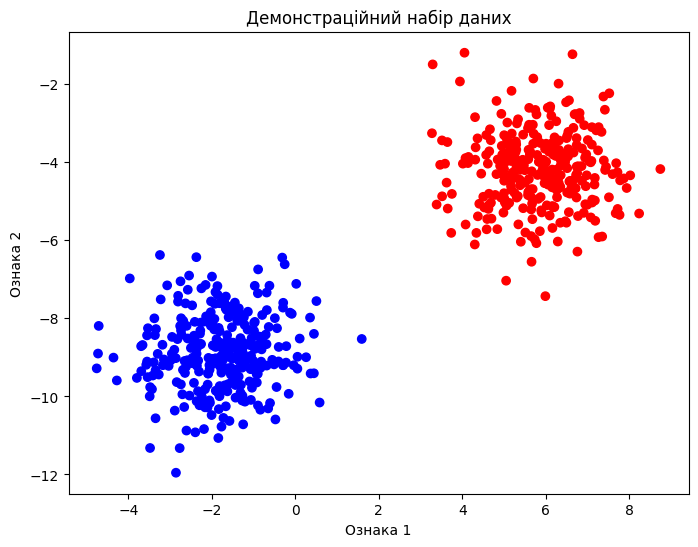

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Генеруємо демонстраційний набір даних
data_features, data_targets = make_blobs(
    n_samples=600, centers=2, n_features=2, random_state=40
)

# Заміна міток: 0 → -1, 1 → +1
transformed_data_targets = [-1 if t == 0 else +1 for t in data_targets]

# Візуалізація набору даних
plt.figure(figsize=(8, 6))
plt.scatter(data_features[:, 0], data_features[:, 1], c=transformed_data_targets, cmap="bwr")
plt.title("Демонстраційний набір даних")
plt.xlabel("Ознака 1")
plt.ylabel("Ознака 2")
# plt.grid(True)
plt.show()

# Поділ даних на навчальну і тестову вибірки
features_train, features_test, labels_train, labels_test = train_test_split(
    data_features, transformed_data_targets, test_size=0.3, random_state=42
)


### 5.2 Визначення класу SVM <a class="anchor" id="primal-svm-class"></a>

Далі буде реалізуємо клас SVM з урахуванням такої інформації:

1. Наша цільова функція з використанням завісної втрати задається наступним чином:
$$
J(\mathbf{w}) = \frac{1}{2}\|\mathbf{w}\|^{2} + C \frac{1}{N} \sum_{n=1}^{N} \max \left\{0,1-y_{n}\left(\left\langle\mathbf{w}, \mathbf{x}_{n}\right\rangle\right)\right\}
$$
2. Ми можемо мінімізувати цю функцію, обчислюючи градієнт:
$$
\nabla_{w} J(\mathbf{w}) = \frac{1}{N} \sum_{n=1}^N \left\{\begin{array}{ll}
\mathbf{w} & \text{якщо} \max \left(0,1-y_{n} \left(\langle \mathbf{w}, \mathbf{x}_{n} \rangle \right)\right)=0 \\
\mathbf{w}-C  y_{n} \mathbf{x}_{n} & \text { інакше }
\end{array}\right.
$$
3. Маючи градієнт, ми можемо використовувати стохастичний градієнтний спуск (SGD), щоб навчити модель.
4. Після навчання моделі ми можемо здійснювати передбачення за допомогою [сигнум-функції](https://uk.wikipedia.org/wiki/Signum-%D1%84%D1%83%D0%BD%D0%BA%D1%86%D1%96%D1%8F).

Як вже зазначалося, ми припускаємо, що зсув $b$ включено до вагового вектора як перший елемент $w_0$, тобто $\mathbf{w} = [b, w_1, ..., w_D] = \mathbf{w} = [w_0, w_1, ..., w_D]$.

In [ ]:
import numpy as np
from sklearn.utils import shuffle

class LinearSVM:

    def __init__(self, regularization_param):
        """
        Ініціалізуємо модель, встановлюючи параметр регуляризації
        та булеву змінну для навчених ваг.
        """
        self.regularization_param = regularization_param
        self.trained_weights = None

    def add_bias_term(self, features):
        """
        Додаємо інтерцепт 1 до кожного тренувального прикладу для біасу b
        """
        n_samples = features.shape[0]
        ones = np.ones((n_samples, 1))
        return np.concatenate((ones, features), axis=1)

    def compute_cost(self, weights, features, labels) -> float:
        """
        Обчислюємо значення функції вартості
        """
        n_samples = features.shape[0]

        # Обчислюємо втрати за допомогою функції хінжа
        predictions = np.dot(features, weights).flatten()
        distances = 1 - labels * predictions
        hinge_losses = np.maximum(0, distances)

        # Обчислюємо суму індивідуальних втрат хінжа
        sum_hinge_loss = np.sum(hinge_losses) / n_samples

        # Обчислюємо загальну вартість
        cost = (1 / 2) * np.dot(weights.T, weights) + self.regularization_param * sum_hinge_loss

        return float(cost)

    def compute_gradient(self, weights, features, labels) -> np.ndarray:
        """
        Обчислюємо градієнт, необхідний для навчання
        """
        predictions = np.dot(features, weights)
        distances = 1 - labels * predictions
        n_samples, n_feat = features.shape
        sub_gradients = np.zeros(n_feat)

        for idx, dist in enumerate(distances):
            if max(0, dist) == 0:
                sub_gradients += weights.T
            else:
                sub_grad = weights.T - (self.regularization_param * features[idx] * labels[idx])
                sub_gradients += sub_grad

        # Сумуємо і ділимо на кількість зразків
        avg_gradient = sub_gradients / len(labels)

        return avg_gradient

    def train(self, train_features, train_labels, n_epochs, learning_rate=0.01, batch_size=1):
        """
        Навчаємо модель за допомогою стохастичного градієнтного спуску,
        використовуючи вказану кількість епох, коефіцієнт навчання та розмір пакету.
        """
        # Додаємо термін біасу до ознак
        train_features = self.add_bias_term(train_features)

        # Ініціалізуємо вектор ваг
        n_samples, n_feat = train_features.shape
        weights = np.zeros(n_feat)[:, np.newaxis]

        # Навчаємо модель певну кількість епох
        for epoch in range(n_epochs):
            features, labels = shuffle(train_features, train_labels)
            start, end = 0, batch_size
            while end <= len(labels): # Цикл навчання через весь набір даних
                batch = features[start:end]
                batch_labels = labels[start:end]

                grad = self.compute_gradient(weights, batch, batch_labels)
                update = learning_rate * grad
                weights = weights - update
                start, end = end, end + batch_size

            current_cost = self.compute_cost(weights, features, labels)
            print(f"Епоха {epoch + 1}, вартість: {current_cost}")

        # Встановлюємо навчені ваги, щоб дозволити робити прогнози
        self.trained_weights = weights

    def predict(self, test_features) -> np.ndarray:
        """
        Прогнозуємо мітки для нових тестових ознак.
        Генерує помилку, якщо модель ще не була навчена.
        """
        test_features = self.add_bias_term(test_features)
        if self.trained_weights is None:
            raise ValueError("Ви ще не навчали SVM!")

        predicted_labels = []
        n_samples = test_features.shape[0]
        for idx in range(n_samples):
            prediction = np.sign(np.dot(self.trained_weights.T, test_features[idx]))
            predicted_labels.append(prediction)

        return np.array(predicted_labels)


In [ ]:
import numpy as np
from sklearn.utils import shuffle

class LinearSVM:

    def __init__(self, regularization_param):
        """
        Ініціалізуємо модель, встановлюючи параметр регуляризації
        та булеву змінну для наших навчених ваг.
        """
        self.regularization_param = regularization_param
        self.trained_weights = None

    def add_bias_term(self, features):
        """
        Додаємо зсув 1 до кожного тренувального прикладу
        """
        n_samples = features.shape[0]
        ones = np.ones((n_samples, 1))
        return np.concatenate((ones, features), axis=1)

    def compute_cost(self, weights, features, labels) -> float:
        """
        Обчислюємо значення функції втрат
        """
        n_samples = features.shape[0]

        # Обчислюємо втрати за допомогою завісної функції
        predictions = np.dot(features, weights).flatten()
        distances = 1 - labels * predictions
        hinge_losses = np.maximum(0, distances)

        # Обчислюємо суму індивідуальних втрат
        sum_hinge_loss = np.sum(hinge_losses) / n_samples

        # Обчислюємо цільову функцію втрат
        cost = (1 / 2) * np.dot(weights.T, weights) + self.regularization_param * sum_hinge_loss

        return float(cost.squeeze())

    def compute_gradient(self, weights, features, labels) -> np.ndarray:
        """
        Обчислюємо градієнт, необхідний для навчання
        """
        predictions = np.dot(features, weights)
        distances = 1 - labels * predictions
        n_samples, n_feat = features.shape
        sub_gradients = np.zeros((1, n_feat))

        for idx, dist in enumerate(distances):
            if max(0, dist) == 0:
                sub_gradients += weights.T
            else:
                sub_grad = weights.T - (self.regularization_param * features[idx] * labels[idx])
                sub_gradients += sub_grad

        # Сумуємо і ділимо на загальну кількість прикладів
        avg_gradient = sum(sub_gradients) / len(labels)

        return avg_gradient

    def train(self, train_features, train_labels, n_epochs, learning_rate=0.01, batch_size=1):
        """
        Train the model with stochastic gradient descent using the
        specified number of epochs, learning rate and batch size.
        """
        # Додаємо доданок зсуву до ознак
        train_features = self.add_bias_term(train_features)

        # Ініціалізуємо вектор ваг
        n_samples, n_feat = train_features.shape
        weights = np.zeros(n_feat)[:, np.newaxis]

        # Навчаємо модель певну кількість епох
        for epoch in range(n_epochs):
            features, labels = shuffle(train_features, train_labels)
            features, labels = train_features, train_labels
            start, end = 0, batch_size
            while end <= len(labels): # Навчальний цикл
                batch = features[start:end]
                batch_labels = labels[start:end]

                grad = self.compute_gradient(weights, batch, batch_labels)
                update = (learning_rate * grad)[:, np.newaxis]
                weights = weights - update
                start, end = end, end + batch_size

            current_cost = self.compute_cost(weights, features, labels)
            print(f"Epoch {epoch + 1}, cost: {current_cost}")

        # Встановлюємо навчені ваги, щоб дозволити робити прогнози
        self.trained_weights = weights

    def predict(self, test_features) -> np.ndarray:
        """
        Прогнозуємо мітки для нових тестових ознак.
        Генерує помилку, якщо модель ще не була навчена.
        """
        test_features = self.add_bias_term(test_features)
        if self.trained_weights is None:
            raise ValueError("Ви ще не навчили SVM!")

        predicted_labels = []
        n_samples = test_features.shape[0]
        for idx in range(n_samples):
            prediction = np.sign(np.dot(self.trained_weights.T, test_features[idx]))
            predicted_labels.append(prediction)

        return np.array(predicted_labels)

In [ ]:
# Обчислюємо деякі значення, щоб переконатися, що вартість обчислюється правильно
# Я спочатку обчислив ці значення вручну для цього прикладу
svm = LinearSVM(regularization_param=1)
weights = np.array([1, 2])[:, np.newaxis]
features = np.array([[0.5], [2.5]])
new_features = svm.add_bias_term(features)

labels = np.array([-1, +1])
assert svm.compute_cost(weights, new_features, labels) == 4.
gradient = svm.compute_gradient(weights, new_features, labels[:, np.newaxis])

### 5.3 Навчання та тестування SVM <a class="anchor" id="train-test-svm"></a>

Після визначення нашого класу SVM ми можемо навчити модель і протестувати її на невідомих (раніше не бачених) прикладах.

In [ ]:
regularization_param = 100
lr = 0.000001
svm = LinearSVM(regularization_param)
trained_weights = svm.train(features_train, labels_train, n_epochs=10, learning_rate=lr)

Epoch 1, cost: 25.486347045686678
Epoch 2, cost: 6.314207367622469
Epoch 3, cost: 3.4193298147764364
Epoch 4, cost: 2.50735468053647
Epoch 5, cost: 1.9840251894767034
Epoch 6, cost: 1.6484990665231762
Epoch 7, cost: 1.3650230805204846
Epoch 8, cost: 1.1782859992568988
Epoch 9, cost: 1.0369935605726348
Epoch 10, cost: 0.9267497108259445


In [ ]:
# Передбачення міток для тестових даних
from sklearn.metrics import accuracy_score, recall_score, precision_score

predicted_labels = svm.predict(features_test)
predicted_labels = predicted_labels.flatten()

print("Точність на тестовому наборі даних: {}".format(accuracy_score(labels_test, predicted_labels)))
print("Повнота на тестовому наборі даних: {}".format(recall_score(labels_test, predicted_labels)))
print("Влучність на тестовому наборі даних: {}".format(precision_score(labels_test, predicted_labels)))

Точність на тестовому наборі даних: 1.0
Повнота на тестовому наборі даних: 1.0
Влучність на тестовому наборі даних: 1.0


### 5.4 Візуалізація границі прийняття рішення <a class="anchor" id="decision-boundary"></a>

Маючи натреновану модель, ми можемо візуалізувати межу прийняття рішення, як показано нижче.

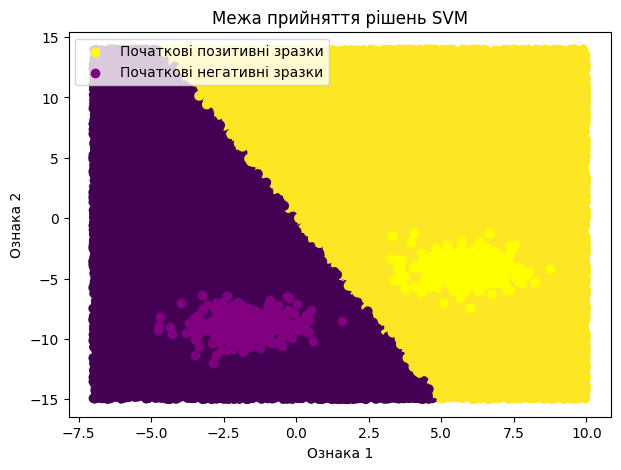

In [ ]:
import numpy as np

# Створюємо набір даних для візуалізації
size = 40000
feat_1 = np.random.uniform(low=-7, high=10, size=size)
feat_2 = np.random.uniform(low=-15, high=14, size=size)
features_vis = np.column_stack((feat_1, feat_2))

# Отримуємо передбачення моделі для візуалізації межі
labels_vis = svm.predict(features_vis)

# Побудова межі прийняття рішень
plt.figure(figsize=(7, 5))
plt.scatter(features_vis[:, 0], features_vis[:, 1], c = labels_vis)

# Відображення початкового набору даних
positive_samples = [idx for idx in range(len(transformed_data_targets)) if transformed_data_targets[idx] == +1]
negative_samples = [idx for idx in range(len(transformed_data_targets)) if transformed_data_targets[idx] == -1]

plt.scatter(data_features[positive_samples, 0],
            data_features[positive_samples, 1],
            c="yellow", label="Початкові позитивні зразки")
plt.scatter(data_features[negative_samples, 0],
            data_features[negative_samples, 1],
            c="purple", label="Початкові негативні зразки")

plt.title("Межа прийняття рішень SVM")
plt.ylabel("Ознака 2")
plt.xlabel("Ознака 1")
plt.legend(loc=2)
plt.show()

## 6. Двоїстий підхід <a class="anchor" id="dual-approach"></a>

У попередніх розділах ми детально розглянули прямий (primal) підхід до побудови SVM. Щоб розв’язати задачу прямого SVM, потрібно знайти оптимальні значення для вагових коефіцієнтів та зміщення. Нагадаємо, що вхідні приклади $\mathbf{x} \in \mathbb{R}^D$ мають $D$ ознак. Відповідно, вектор ваг $\mathbf{w}$ також має $D$ компонент. Це може стати проблемою, якщо кількість ознак $D$ є великою.

Саме тут на допомогу приходить інший спосіб формалізації SVM — так званий двоїстий підхід (dual approach). У цьому випадку оптимізаційна задача не залежить від кількості ознак. Натомість, кількість параметрів зростає з кількістю прикладів у навчальній вибірці.

Двоїстий підхід базується на методі множників Лагранжа. Множники Лагранжа дозволяють знайти мінімум або максимум функції за наявності одного або кількох обмежень на вхідні значення.

Якщо ви ще не чули про множники Лагранжа, рекомендую ознайомитися з [блогом](https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/constrained-optimization/a/lagrange-multipliers-single-constraint) та [відео](https://www.youtube.com/watch?v=yuqB-d5MjZA&list=PLCg2-CTYVrQvNGLbd-FN70UxWZSeKP4wV&index=1) від Khan Academy.


### 6.1 Підсумок про множники Лагранжа <a class="anchor" id="recap-lagrange-multipliers"></a>

Множники Лагранжа дозволяють розв’язувати задачі оптимізації з обмеженнями. Припустимо, ми хочемо максимізувати функцію $f(x, y) = 2x + y$ за умови, що значення $x$ та $y$ задовольняють наступне рівняння обмеження: $g(x, y) := x^2 + y^2 = 1$. Це рівняння описує коло радіуса 1.

Ключова ідея рішення такої задачі полягає в тому, щоб знайти такі значення $x$ і $y$, при яких градієнти функцій $f$ і $g$ співнапрямлені. Це можна виразити через множник Лагранжа (зазвичай позначається $\lambda$).

Ми хочемо знайти такі значення $x_m, y_m$, для яких виконується $\nabla f(x_m, y_m) = \lambda \nabla g(x_m, y_m)$.

У нашому прикладі градієнти виглядають так:

$$ \nabla f(x, y)=\left[\begin{array}{c}
\frac{\partial}{\partial x}(2 x+y) \\
\frac{\partial}{\partial y}(2 x+y)
\end{array}\right]=\left[\begin{array}{c}
2 \\ 1
\end{array}\right]$$

$$ \nabla g(x, y)=\left[\begin{array}{c}
\frac{\partial}{\partial x}\left(x^{2}+y^{2}-1\right) \\
\frac{\partial}{\partial y}\left(x^{2}+y^{2}-1\right)
\end{array}\right]=\left[\begin{array}{c}
2 x \\ 2 y
\end{array}\right]$$

Отже, умова дотичності дає рівняння:
$$ \left[\begin{array}{l}
2 \\ 1
\end{array}\right]=\lambda \left[\begin{array}{l}
2 x_{m} \\ 2 y_{m}
\end{array}\right] $$

Ми можемо переписати векторну форму в окремі рівняння, які можна розв'язати вручну:
- $2 = \lambda 2 x_m $    
- $1 = \lambda 2 y_m $    
- $x_m^2 + y_m^2 = 1 $

Розв'язуючи ці рівняння, отримуємо:
$$ \begin{aligned}
\left(x_{0}, y_{0}\right) &=\left(\frac{1}{\lambda_{0}}, \frac{1}{2 \lambda_{0}}\right) \\
&=\left(\frac{2}{\sqrt{5}}, \frac{1}{\sqrt{5}}\right) \quad \text { or } \quad\left(\frac{-2}{\sqrt{5}}, \frac{-1}{\sqrt{5}}\right)
\end{aligned} $$

Перша точка відповідає максимуму (що ми й шукали), а друга — мінімуму. Це розв’язує нашу задачу оптимізації з обмеженням. Більше деталей та повне пояснення можна знайти у [цьому пості Khan Academy](https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/constrained-optimization/a/lagrange-multipliers-single-constraint).

### 6.2 Лагранжіан  <a class="anchor" id="recap-lagrangian"></a>

**Лагранжіан** — це математичний інструмент, який дозволяє перетворити задачу оптимізації з обмеженнями на задачу без обмежень, додавши ці обмеження до цільової функції через спеціальні множники (лагранжеві множники). У наведеному вище прикладі ми хотіли оптимізувати деяку функцію $f(x, y)$ за умови, що вхідні значення $x$ і $y$ задовольняють рівняння $g(x, y) = x^2 + y^2 = c$. У нашому випадку сталою $c$ було число 1. Ми знаємо, що розв’язком є ті точки, в яких градієнти $f$ і $g$ співнаправлені.

Лагранжіан поєднує це все в одне рівняння:

$$ \mathcal{L}(x, y, \lambda)=f(x, y)-\lambda(g(x, y)-c) $$

Коли ми обчислюємо часткові похідні $\mathcal{L}$ за $x$, $y$ і $\lambda$ та прирівнюємо їх до нуля, ми отримаємо рівняння, що відповідають тим трьом умовам, які ми розглядали раніше. У стислій формі це записується як:
 $$\nabla \mathcal{L} = \mathbf{0}$$

Компактна форма лагранжіана часто використовується при розв’язанні задач оптимізації з обмеженнями на комп’ютері, оскільки вона зводить складну задачу з кількома обмеженнями до одного рівняння.

### 6.3 Проблема дуальної оптимізації  <a class="anchor" id="dual-optimization-problem"></a>
Для прямої (primal) задачі SVM із м’якими межами (soft-margin SVM) ми розглядали таку задачу оптимізації:

$$ \min_{\mathbf{w}, b, \mathbf{\xi}} \frac{1}{2} \Vert \mathbf{w} \Vert^2 + C \sum_{n=1}^N \xi_n $$

$$ \text{за умов:} $$

$$ \begin{equation}
y_n(\langle \mathbf{w}, \mathbf{x}_n \rangle + b) \ge 1 - \xi_n
\end{equation}$$

$$ \xi_i \ge 0 \;\; \forall n = 1, ..., N $$

Щоб отримати відповідний Лагранжіан, ми вводимо два множники Лагранжа:
- $\alpha_n$ — для першого обмеження: правильна класифікація з урахуванням помилок (тобто $y_n(\mathbf{w}^T \mathbf{x}_n + b) \geq 1 - \xi_n$),
- $\lambda_n$ — для другого обмеження: невід’ємність змінних штрафу (тобто $\xi_n \geq 0$). Лагранжіан (Lagrangian) для цієї задачі має вигляд:

$$
\begin{aligned}
\mathcal{L}(\boldsymbol{w}, b, \xi, \alpha, \gamma)=& \frac{1}{2}\|\boldsymbol{w}\|^{2}+C \sum_{n=1}^{N} \xi_{n} \\
& \underbrace{-\sum_{n=1}^{N} \alpha_{n}\left(y_{n}\left(\left\langle\boldsymbol{w}, \boldsymbol{x}_{n}\right\rangle+b\right)-1+\xi_{n}\right)}_{\text{перше обмеження}} \underbrace{-\sum_{n=1}^{N} \gamma_{n} \xi_{n}}_{\text{друге обмеження}}
\end{aligned}
$$

Далі нам потрібно обчислити часткові похідні Лагранжіана за змінними $\mathbf{w}, b$ та $\xi$:
$\frac{\partial \mathcal{L}}{\partial \mathbf{w}}, \frac{\partial \mathcal{L}}{\partial b}, \frac{\partial \mathcal{L}}{\partial \xi}$.

При прирівнюванні першої часткової похідної до нуля ми отримуємо важливий проміжний результат:

$$ \mathbf{w} = \sum_{n=1}^N \alpha_n y_n \mathbf{x}_n $$

Це рівняння вказує на те, що оптимальне значення вектора ваг задається як лінійна комбінація навчальних прикладів. Після прирівнювання інших похідних до нуля, підставлення цього результату та спрощення рівнянь ми отримуємо наступну задачу оптимізації (деталі див. у розділі 12.3.1 книги [Mathematics for Machine Learning](https://mml-book.com)):

$$\min _{\boldsymbol{\alpha}} \frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} y_{i} y_{j} \alpha_{i} \alpha_{j}\left\langle\mathbf{x}_{i}, \mathbf{x}_{j}\right\rangle-\sum_{i=1}^{N} \alpha_{i}$$
$$ \text{за умов:} $$
$$\sum_{i=1}^{N} y_{i} \alpha_{i}=0$$
$$0 \le \alpha_{i} \le C \;\; \forall i=1, \ldots, N$$


Цю задачу квадратичної оптимізації з обмеженнями можна розв’язувати дуже ефективно, наприклад, за допомогою методів квадратичного програмування. Однією з популярних бібліотек для розв’язання дуальних SVM є [libsvm](https://github.com/cjlin1/libsvm), яка використовує метод декомпозиції для пошуку розв’язку (див. [цю статтю](https://www.csie.ntu.edu.tw/~cjlin/papers/libsvm.pdf) для деталей). Водночас існують і інші підходи.

## 7. Прямий (primal) та двоїстий (dual) підходи <a class="anchor" id="primal-vs-dual"></a>

Більшість досліджень SVM за останнє десятиліття були зосереджені на двоїстій формулюванні. Чому так склалося — не зовсім ясно. Обидва підходи мають свої переваги та недоліки. У статті ["Training a Support Vector Machine in the Primal"](https://pure.mpg.de/rest/items/item_1790269_2/component/file_3080690/content) Шапель висловлює таку гіпотезу:

> Ми вважаємо, що це пов’язано з тим, що SVM спочатку були представлені у формі з жорстким зазором (hard margin) (Boser та ін., 1992), для якої двоїста оптимізація (через наявність обмежень) виглядає природнішою. Загалом же, слід надавати перевагу SVM із м’яким зазором (soft margin), навіть якщо навчальні дані є лінійно роздільними: межа прийняття рішення є більш стійкою, оскільки враховується більше навчальних точок (Chapelle та ін., 2000). Ми не стверджуємо, що пряма оптимізація є загалом кращою; наша основна мотивація — підкреслити, що пряме та двоїсте формулювання — це дві сторони однієї медалі, й немає підстав завжди дивитися лише на одну сторону.

## 8. Ядра / Нелінійні SVM <a class="anchor" id="kernel-svms"></a>

### 8.1 Що таке ядро? <a class="anchor" id="what-is-a-kernel"></a>
Якщо ще раз подивитися на рівняння оптимізації для двоїстого формулювання SVM, можна помітити, що воно обчислює скалярний добуток $\left\langle\mathbf{x}_{i}, \mathbf{x}_{j}\right\rangle$ між усіма парами точок $\mathbf{x}_{i}, \mathbf{x}_{j}$.

Ядро — це спосіб неявного обчислення такого скалярного добутку в деякому (можливо, дуже високовимірному) просторі ознак. Точніше: припустимо, що існує деяка функція відображення $\varphi \, : \, \mathbb R^n \to \mathbb R^m$, яка відображає $n$-вимірний вхідний вектор у $m$-вимірний простір ознак. Тоді ми можемо обчислити скалярний добуток двох векторів $\mathbf x$ та $\mathbf y$ в цьому просторі так: $\varphi(\mathbf x)^T \varphi(\mathbf y)$.

Ядро — це функція $k$, яка дає той самий результат, що і цей скалярний добуток:
$k(\mathbf x, \mathbf y) = \varphi(\mathbf x)^T \varphi(\mathbf y)$. Іншими словами, функція ядра еквівалентна скалярному добутку у просторі ознак, визначеному функцією відображення $\varphi$.

### 8.2 Для чого потрібні ядра? <a class="anchor" id="what-are-kernels-good-for"></a>

До цього моменту (за винятком SVM із м’яким зазором) наші SVM — як прямі, так і двоїсті — здатні класифікувати лише лінійно роздільні дані ([linearly separable](https://en.wikipedia.org/wiki/Linear_separability)). Проте на практиці більшість наборів даних такими не є. Нам потрібен спосіб класифікації даних, які не є лінійно роздільними. І тут у гру вступає так званий **прийом ядра** (kernel trick).

Оскільки цільова функція у двоїстому формулюванні SVM містить лише скалярні добутки між точками даних $\mathbf{x}_i, \mathbf{x}_j$, ми можемо легко замінити цей скалярний добуток (тобто $\left\langle\mathbf{x}_{i}, \mathbf{x}_{j}\right\rangle$) на деяке відображення $\varphi(\mathbf{x}_i)^T \varphi(\mathbf{x}_j)$. Це відображення може бути нелінійним, що дозволяє побудувати SVM, який є нелінійним відносно вхідних прикладів. Така функція відображення трансформує наші вхідні дані (які не є лінійно роздільними) у простір вищої розмірності, де вони вже стають лінійно роздільними. Це проілюстровано на рисунку нижче.

<img src="https://docs.google.com/uc?export=download&id=1fP5CWkEdsxMeJGCE0ulDxyd6xqPdMYiB" width="900"/>

Теоретично ми можемо використовувати будь-яке відображення, яке забажаємо. Але на практиці обчислення скалярних добутків у просторі вищої розмірності є дорогим. Тому ми використовуємо такі функції відображення, для яких існує відповідна функція ядра. Це дозволяє нам працювати в просторі високої розмірності, **не обчислюючи явно** дорогі скалярні добутки.

Розглянемо приклад.

### 8.3 Приклад <a class="anchor" id="kernel-example"></a>

Ми можемо створити просте поліноміальне ядро наступним чином: $k(\mathbf{x}, \mathbf{y}) = (1 + \mathbf x^T \mathbf y)^2$, де  $\mathbf x, \mathbf y \in \mathbb R^2$. На перший погляд, це ядро не пов’язане з якоюсь функцією відображення $\varphi$ — воно просто повертає дійсне число. Наші вхідні вектори $\mathbf{x}, \mathbf{y}$ мають дві координати: $\mathbf x = (x_1, x_2)$ і $\mathbf y = (y_1, y_2)$. Маючи це, можемо розкласти обчислення ядра наступним чином:

$\begin{align*}
k(\mathbf x, \mathbf y) & = (1 + \mathbf x^T \mathbf y)^2 \\
&= (1 + x_1 \, y_1  + x_2 \, y_2)^2 \\
 & = 1 + x_1^2 y_1^2 + x_2^2 y_2^2 + 2 x_1 y_1 + 2 x_2 y_2 + 2 x_1 x_2 y_1 y_2
\end{align*}$

Зверніть увагу, що це ніщо інше, як скалярний добуток між двома векторами: $(1, x_1^2, x_2^2, \sqrt{2} x_1, \sqrt{2} x_2, \sqrt{2} x_1 x_2)$ and $(1, y_1^2, y_2^2, \sqrt{2} y_1, \sqrt{2} y_2, \sqrt{2} y_1 y_2)$. Це можна записати через наступну функцію відображення:
$$\varphi(\mathbf x) = \varphi(x_1, x_2) = (1, x_1^2, x_2^2, \sqrt{2} x_1, \sqrt{2} x_2, \sqrt{2} x_1 x_2)$$

Таким чином, ядро: $k(\mathbf x, \mathbf y) = (1 + \mathbf x^T \mathbf y)^2 = \varphi(\mathbf x)^T \varphi(\mathbf y)$ обчислює скалярний добуток у 6-вимірному просторі, не переходячи явно до цього простору. Узагальнення скалярного добутку до функції ядра відоме під назвою п**рийом ядра (kernel trick)**.

снує багато популярних функцій ядра. Наприклад,[поліноміальне ядро](https://en.wikipedia.org/wiki/Polynomial_kernel) та [радіально-базисне ядро (RBF)](https://en.wikipedia.org/wiki/Radial_basis_function_kernel).

### 8.4 Чи можна також використовувати ядра в прямій (primal) формі SVM? <a class="anchor" id="kernel-in-primal-svm"></a>

Так, **прийом ядра (kernel trick)** можна застосовувати і в прямій формі SVM. Це не так просто і природно, як у випадку з двоїстою формою, але все ж можливо. Як приклад, зверніться до [цієї статті Шапеля](https://pure.mpg.de/rest/items/item_1791063_2/component/file_3009835/content), де продемонстровано, як це реалізується на практиці.

### 8.5 Як обрати правильне ядро для своєї задачі?  <a class="anchor" id="choosing-the-right-kernel"></a>

Підсумок:

- Без спеціальних знань хорошим вибором за замовчуванням є радіально-базисне ядро (RBF kernel), якщо вам потрібна нелінійна модель.

- Вибір ядра та його параметрів можна автоматизувати за допомогою крос-валідації для підбору моделі.

- Автоматичний вибір ядра і параметрів — складне завдання, оскільки дуже легко перенавчити модель на критерій вибору (тобто модель буде добре працювати на валідації, але погано на нових даних).

## 9. Джерела та додаткова література <a class="anchor" id="sources"></a>

1. Підготовлено блокнот на основі блогу Анна-Лена Попкес [Support vector machines](https://alpopkes.com/posts/machine_learning/support_vector_machines/) та 12 розділу книги [Mathematics for Machine Learning](https://mml-book.github.io/).

2. [Лекція MIT про метод опорних векторів (SVM)](https://www.youtube.com/watch?v=_PwhiWxHK8o).